In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium, plotly
import missingno as msno
from statsmodels.formula.api import ols
from matplotlib.widgets import Slider, Button, RadioButtons
from google.colab import drive
drive.mount('/content/drive/')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



Mounted at /content/drive/


In [2]:
# data downloaded from https://www.emdat.be/ choosing all labeled as "Natural Disaster"
disasters = pd.read_excel('/content/drive/MyDrive/DS4A-W_Team25/Colab_Files/data/natural_disasters.xlsx', header = 6)
disasters.head()

,Dis No,Year,Seq,Glide,Disaster Group,Disaster Subgroup,Disaster Type,Disaster Subtype,Disaster Subsubtype,Event Name,Country,ISO,Region,Continent,Location,Origin,Associated Dis,Associated Dis2,OFDA Response,Appeal,Declaration,Aid Contribution,Dis Mag Value,Dis Mag Scale,Latitude,Longitude,Local Time,River Basin,Start Year,Start Month,Start Day,End Year,End Month,End Day,Total Deaths,No Injured,No Affected,No Homeless,Total Affected,Reconstruction Costs ('000 US$),Insured Damages ('000 US$),Total Damages ('000 US$),CPI,Adm Level,Admin1 Code,Admin2 Code,Geo Locations
0,1900-9002-CPV,1900,9002,NaN,Natural,Climatological,Drought,Drought,NaN,NaN,Cabo Verde,CPV,Western Africa,Africa,Countrywide,NaN,Famine,NaN,NaN,No,No,NaN,NaN,Km2,NaN,NaN,NaN,NaN,1900,NaN,NaN,1900,NaN,NaN,11000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.221647,NaN,NaN,NaN,NaN
1,1900-9001-IND,1900,9001,NaN,Natural,Climatological,Drought,Drought,NaN,NaN,India,IND,Southern Asia,Asia,Bengal,NaN,NaN,NaN,NaN,No,No,NaN,NaN,Km2,NaN,NaN,NaN,NaN,1900,NaN,NaN,1900,NaN,NaN,1250000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.221647,NaN,NaN,NaN,NaN
2,1902-0012-GTM,1902,12,NaN,Natural,Geophysical,Earthquake,Ground movement,NaN,NaN,Guatemala,GTM,Central America,Americas,"Quezaltenango, San Marcos",NaN,Tsunami/Tidal wave,NaN,NaN,NaN,NaN,NaN,8.0,Richter,14,-91,20:20,NaN,1902,4.0,18.0,1902,4.0,18.0,2000.0,NaN,NaN,NaN,NaN,NaN,NaN,25000.0,3.350513,NaN,NaN,NaN,NaN
3,1902-0003-GTM,1902,3,NaN,Natural,Geophysical,Volcanic activity,Ash fall,NaN,Santa Maria,Guatemala,GTM,Central America,Americas,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1902,4.0,8.0,1902,4.0,8.0,1000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.350513,NaN,NaN,NaN,NaN
4,1902-0010-GTM,1902,10,NaN,Natural,Geophysical,Volcanic activity,Ash fall,NaN,Santa Maria,Guatemala,GTM,Central America,Americas,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1902,10.0,24.0,1902,10.0,24.0,6000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.350513,NaN,NaN,NaN,NaN


In [3]:
disasters.columns = disasters.columns.str.lower()

In [4]:
disasters.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16121 entries, 0 to 16120
Data columns (total 47 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   dis no                           16121 non-null  object 
 1   year                             16121 non-null  int64  
 2   seq                              16121 non-null  int64  
 3   glide                            1581 non-null   object 
 4   disaster group                   16121 non-null  object 
 5   disaster subgroup                16121 non-null  object 
 6   disaster type                    16121 non-null  object 
 7   disaster subtype                 13012 non-null  object 
 8   disaster subsubtype              1077 non-null   object 
 9   event name                       3858 non-null   object 
 10  country                          16121 non-null  object 
 11  iso                              16121 non-null  object 
 12  region            

In [5]:
# I don't know what `cpi` is
disasters['cpi'].unique

<bound method Series.unique of 0        3.221647
1        3.221647
2        3.350513
3        3.350513
4        3.350513
           ...   
16116         NaN
16117         NaN
16118         NaN
16119         NaN
16120         NaN
Name: cpi, Length: 16121, dtype: float64>

CPI may stand for Community Prepardness Index. 

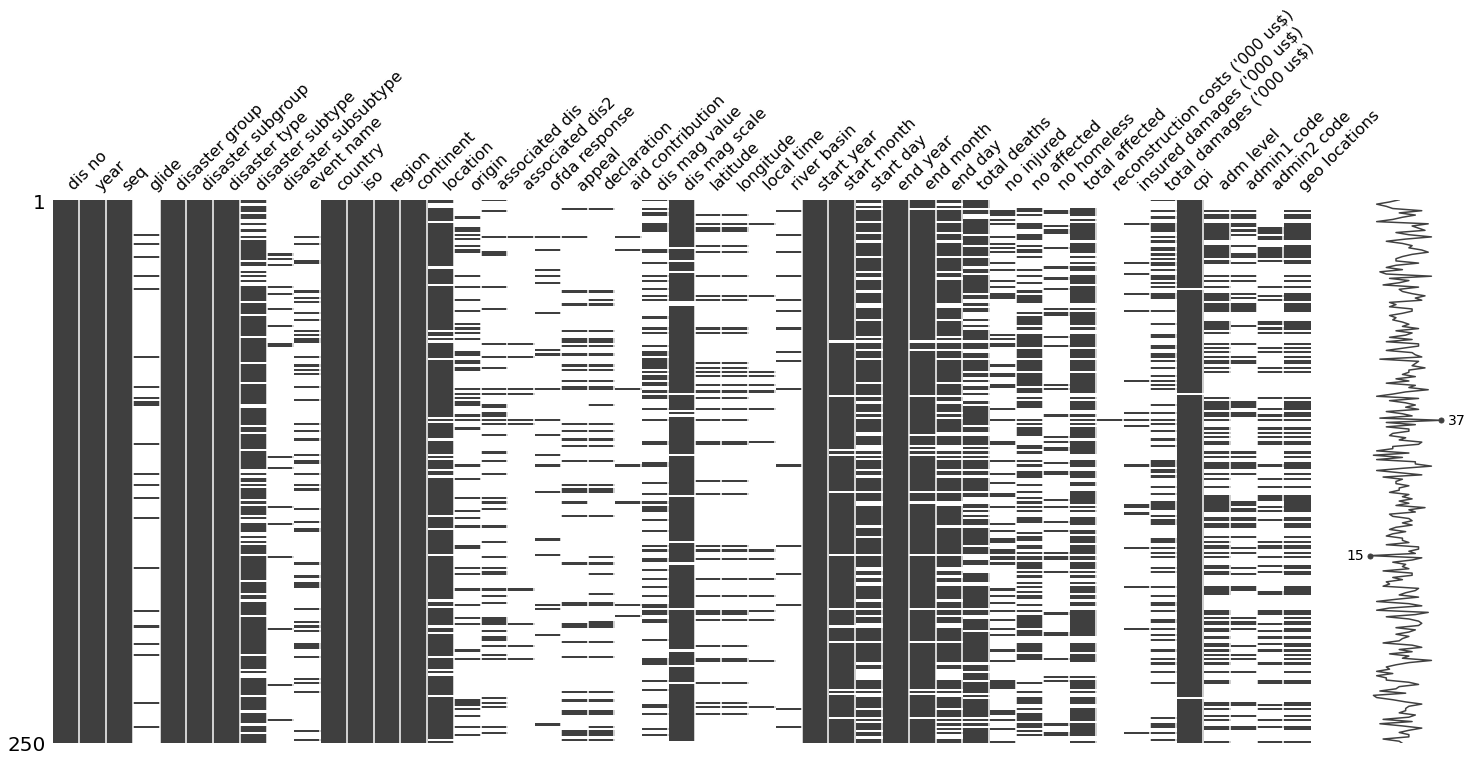

In [6]:
# checking for missing data
msno.matrix(disasters.sample(250));

In [7]:
# looking if there are any duplicates
len(disasters['dis no'].unique())

16121

This matches the number of entries.

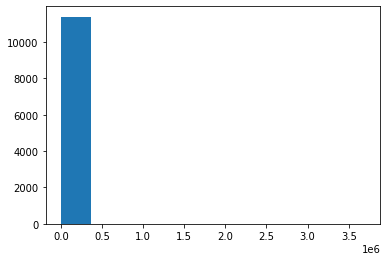

In [8]:
# total deaths distribution
plt.hist(disasters['total deaths']);

Most disasers have no deaths

In [9]:
# need a column of total humans affected by the disasters, which would be the sum of total deaths and total affected
disasters['total_human_affected'] = disasters.loc[:, ['total affected','total deaths']].sum(axis=1)

In [10]:
disasters.head()

,dis no,year,seq,glide,disaster group,disaster subgroup,disaster type,disaster subtype,disaster subsubtype,event name,country,iso,region,continent,location,origin,associated dis,associated dis2,ofda response,appeal,declaration,aid contribution,dis mag value,dis mag scale,latitude,longitude,local time,river basin,start year,start month,start day,end year,end month,end day,total deaths,no injured,no affected,no homeless,total affected,reconstruction costs ('000 us$),insured damages ('000 us$),total damages ('000 us$),cpi,adm level,admin1 code,admin2 code,geo locations,total_human_affected
0,1900-9002-CPV,1900,9002,NaN,Natural,Climatological,Drought,Drought,NaN,NaN,Cabo Verde,CPV,Western Africa,Africa,Countrywide,NaN,Famine,NaN,NaN,No,No,NaN,NaN,Km2,NaN,NaN,NaN,NaN,1900,NaN,NaN,1900,NaN,NaN,11000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.221647,NaN,NaN,NaN,NaN,11000.0
1,1900-9001-IND,1900,9001,NaN,Natural,Climatological,Drought,Drought,NaN,NaN,India,IND,Southern Asia,Asia,Bengal,NaN,NaN,NaN,NaN,No,No,NaN,NaN,Km2,NaN,NaN,NaN,NaN,1900,NaN,NaN,1900,NaN,NaN,1250000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.221647,NaN,NaN,NaN,NaN,1250000.0
2,1902-0012-GTM,1902,12,NaN,Natural,Geophysical,Earthquake,Ground movement,NaN,NaN,Guatemala,GTM,Central America,Americas,"Quezaltenango, San Marcos",NaN,Tsunami/Tidal wave,NaN,NaN,NaN,NaN,NaN,8.0,Richter,14,-91,20:20,NaN,1902,4.0,18.0,1902,4.0,18.0,2000.0,NaN,NaN,NaN,NaN,NaN,NaN,25000.0,3.350513,NaN,NaN,NaN,NaN,2000.0
3,1902-0003-GTM,1902,3,NaN,Natural,Geophysical,Volcanic activity,Ash fall,NaN,Santa Maria,Guatemala,GTM,Central America,Americas,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1902,4.0,8.0,1902,4.0,8.0,1000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.350513,NaN,NaN,NaN,NaN,1000.0
4,1902-0010-GTM,1902,10,NaN,Natural,Geophysical,Volcanic activity,Ash fall,NaN,Santa Maria,Guatemala,GTM,Central America,Americas,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1902,10.0,24.0,1902,10.0,24.0,6000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.350513,NaN,NaN,NaN,NaN,6000.0


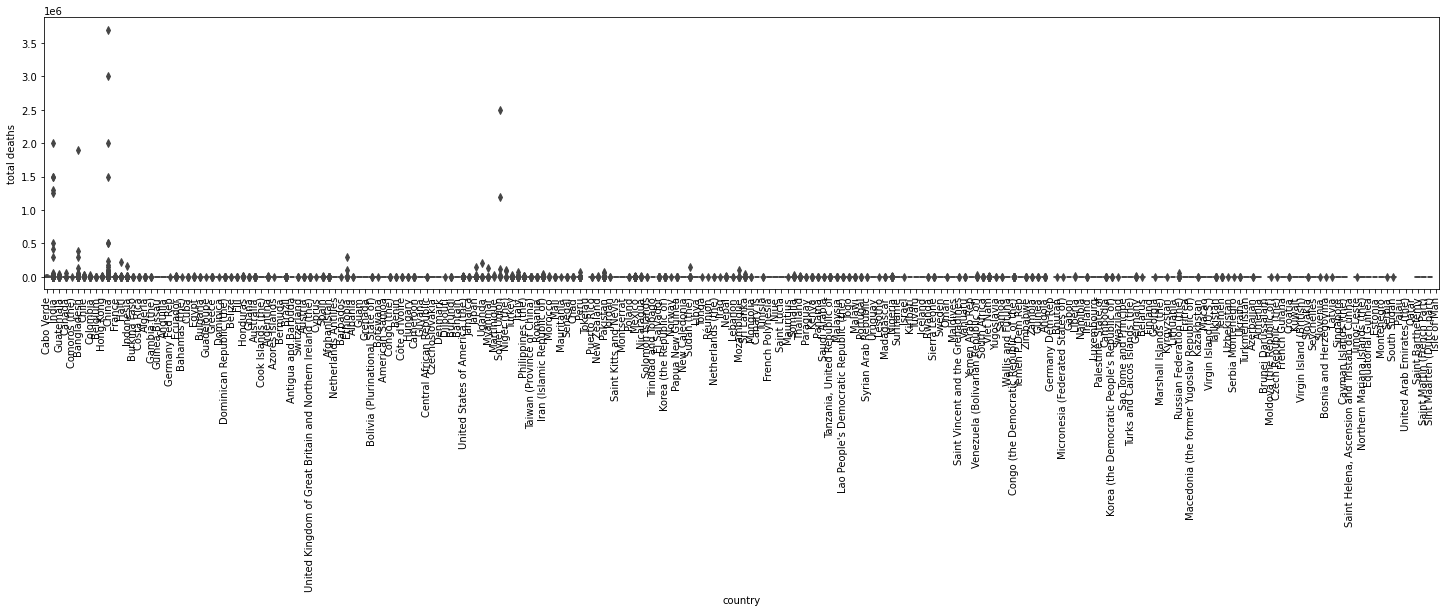

In [11]:
plt.figure(figsize=(25,5))
sns.boxplot(y=disasters['total deaths'], x=disasters['country'], orient='v')
plt.xticks(rotation=90);

There are some countries that are outliers, but for the most part, death rate due to natural disasters is low.

In [12]:
# disasters over time
total_disasters = disasters.groupby('year').size().to_frame()
total_disasters.columns = ['total disasters']

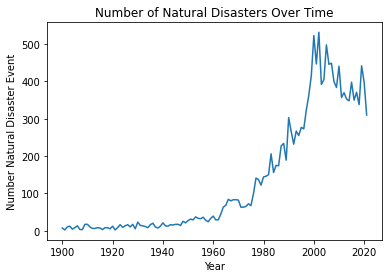

In [13]:
total_disasters.plot(legend=False, title='Number of Natural Disasters Over Time')
plt.xlabel('Year')
plt.ylabel('Number Natural Disaster Event')
plt.savefig('/content/drive/MyDrive/DS4A-W_Team25/Colab_Files/figures/disasters_per_year.png');

In [14]:
# look at each disaster subtype per year
disasters_year = disasters.pivot_table(index='year', columns='disaster subgroup', values='dis no', aggfunc='size')
disasters_year

disaster subgroup,Biological,Climatological,Extra-terrestrial,Geophysical,Hydrological,Meteorological
year,,,,,,
1900,1.0,2.0,NaN,2.0,1.0,1.0
1901,1.0,NaN,NaN,1.0,NaN,NaN
1902,NaN,NaN,NaN,9.0,NaN,1.0
1903,NaN,1.0,NaN,7.0,2.0,2.0
1904,NaN,NaN,NaN,3.0,NaN,1.0
...,...,...,...,...,...,...
2017,27.0,27.0,NaN,25.0,152.0,140.0
2018,16.0,27.0,NaN,30.0,141.0,124.0
2019,44.0,29.0,NaN,36.0,221.0,112.0


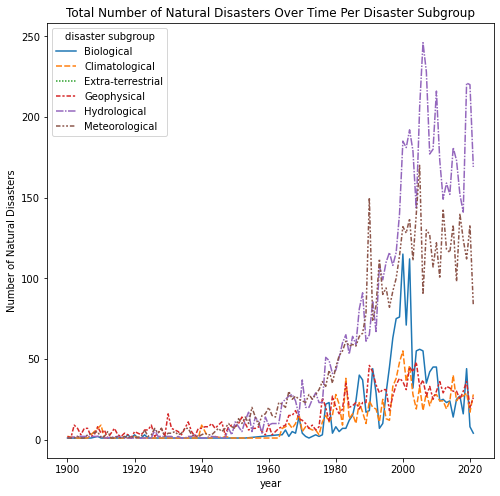

In [15]:
plt.figure(figsize=(8,8))
sns.lineplot(data=disasters_year)
plt.ylabel('Number of Natural Disasters')
plt.title('Total Number of Natural Disasters Over Time Per Disaster Subgroup')
plt.savefig('/content/drive/MyDrive/DS4A-W_Team25/Colab_Files/figures/disater_type_per_year.png');

In [16]:
# it doesn't look like there are extra-terrastrial events, so I'm double checking
disasters_year['Extra-terrestrial'].isna().sum()

121

There is only one extra-terrestrial event. Taking a look at whether this event caused any casualties/damage.

In [17]:
disasters[disasters['disaster subgroup'] == 'Extra-terrestrial'][["dis no", "year", "disaster subgroup", "country", "total deaths", "total affected", "reconstruction costs ('000 us$)", "total damages ('000 us$)"]]

,dis no,year,disaster subgroup,country,total deaths,total affected,reconstruction costs ('000 us$),total damages ('000 us$)
12856,2013-0060-RUS,2013,Extra-terrestrial,Russian Federation (the),NaN,301491.0,NaN,33000.0


Significant number of people were affected, so I will keep the event for the analysis.

In [18]:
# group by country and year
dis_year_country = disasters.groupby(['year','country']).size().to_frame()
dis_year_country.columns = ['total disasters']

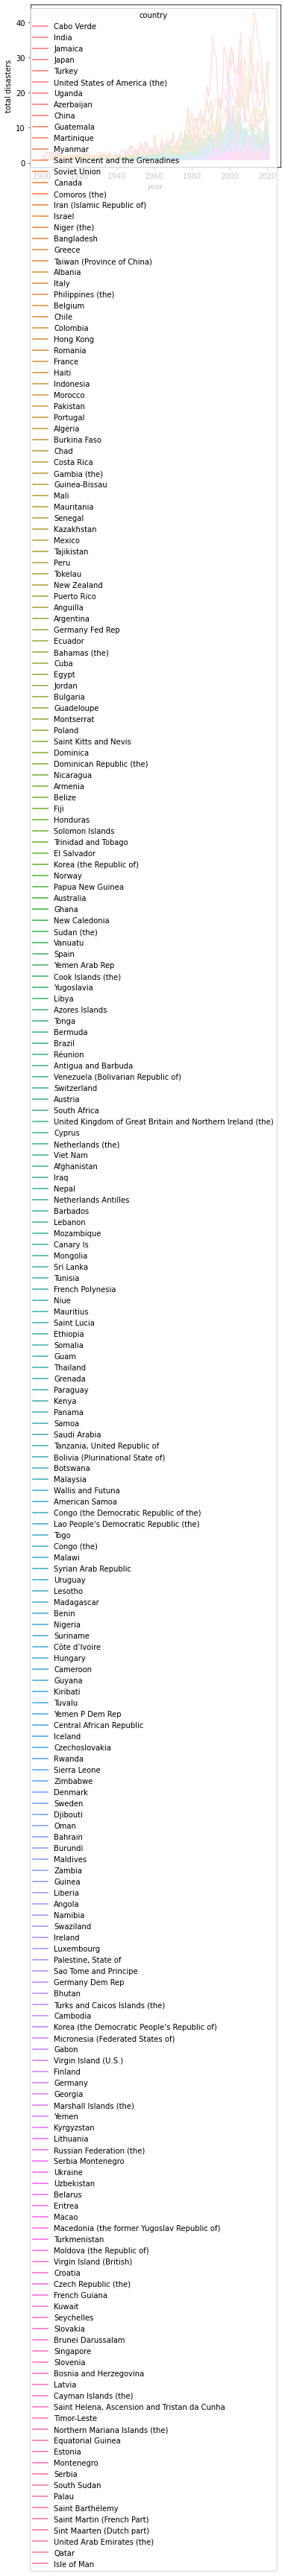

In [19]:
# plot per country
sns.lineplot(x='year', y='total disasters', hue='country', data=dis_year_country);

In [20]:
# plot only top 10 countries
dis_country = disasters.groupby(['country']).count()[['dis no']].sort_values('dis no', ascending=False)
top_10 = dis_country.reset_index().iloc[:10, 0].to_list()

In [21]:
dis_country.head(10)

,dis no
country,
United States of America (the),1087
China,980
India,752
Philippines (the),668
Indonesia,572
Japan,375
Bangladesh,356
Mexico,292
Iran (Islamic Republic of),251


In [22]:
top_10_countries = disasters[disasters['country'].isin(top_10)]
top_10_year_country = top_10_countries.groupby(['year','country']).size().to_frame()
top_10_year_country.columns = ['total disasters']

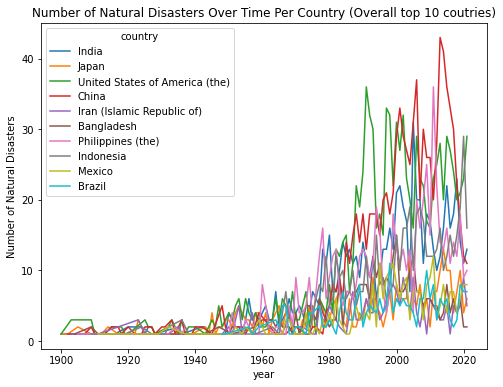

In [23]:
plt.figure(figsize=(8, 6))
sns.lineplot(x='year', y='total disasters', hue='country', data=top_10_year_country)
plt.ylabel('Number of Natural Disasters')
plt.title('Number of Natural Disasters Over Time Per Country (Overall top 10 coutries)');

In [24]:
disasters.columns

Index(['dis no', 'year', 'seq', 'glide', 'disaster group', 'disaster subgroup',
       'disaster type', 'disaster subtype', 'disaster subsubtype',
       'event name', 'country', 'iso', 'region', 'continent', 'location',
       'origin', 'associated dis', 'associated dis2', 'ofda response',
       'appeal', 'declaration', 'aid contribution', 'dis mag value',
       'dis mag scale', 'latitude', 'longitude', 'local time', 'river basin',
       'start year', 'start month', 'start day', 'end year', 'end month',
       'end day', 'total deaths', 'no injured', 'no affected', 'no homeless',
       'total affected', 'reconstruction costs ('000 us$)',
       'insured damages ('000 us$)', 'total damages ('000 us$)', 'cpi',
       'adm level', 'admin1 code', 'admin2 code', 'geo locations',
       'total_human_affected'],
      dtype='object')

In [25]:
dis_country_subgroup = disasters.groupby(['country', 'disaster subgroup']).count()[['dis no']] #.sort_values('dis no', ascending=False)
# top_10 = dis_country.reset_index().iloc[:10, 0].to_list()
dis_country_subgroup.loc['United States of America (the)',]

,dis no
disaster subgroup,
Biological,5
Climatological,108
Geophysical,47
Hydrological,206
Meteorological,721


In [26]:
dis_country_subgroup.loc['China',]

,dis no
disaster subgroup,
Biological,11
Climatological,47
Geophysical,206
Hydrological,384
Meteorological,332


In [27]:
dis_country_subgroup.loc['India',]

,dis no
disaster subgroup,
Biological,71
Climatological,22
Geophysical,29
Hydrological,364
Meteorological,266


In [28]:
dis_country_subgroup.loc['Philippines (the)',]

,dis no
disaster subgroup,
Biological,24
Climatological,11
Geophysical,72
Hydrological,186
Meteorological,375


In [29]:
dis_country_subgroup.loc['Indonesia',]

,dis no
disaster subgroup,
Biological,35
Climatological,21
Geophysical,196
Hydrological,306
Meteorological,14


In [30]:
dis_country_subgroup.loc['Japan',]

,dis no
disaster subgroup,
Biological,3
Climatological,2
Geophysical,85
Hydrological,82
Meteorological,203


In [31]:
# largest subgroup
disasters.groupby(['disaster subgroup']).count()[['dis no']].sort_values('dis no', ascending=False)

,dis no
disaster subgroup,
Hydrological,6326
Meteorological,5098
Geophysical,1856
Biological,1597
Climatological,1243
Extra-terrestrial,1


Country-level analysis is messy.

In [32]:
m = folium.Map()

#Setting up the world countries data URL
url = 'https://raw.githubusercontent.com/python-visualization/folium/master/examples/data'
country_shapes = f'{url}/world-countries.json'

folium.Choropleth(
    #The GeoJSON data to represent the world country
    geo_data=country_shapes,
    name='Natural Disasters',
    data=disasters,
    #The column accepting list with 2 value; The country name and  the numerical value
    columns=['iso', 'total disasters'],
    key_on='feature.properties.name',
    fill_color='YlGnBu',
    nan_fill_color=''
).add_to(m)
m

KeyError: ignored

In [33]:
disaster_damages = disasters.groupby('year').sum()[['total deaths', 'total affected', "total damages ('000 us$)", 'total_human_affected']]

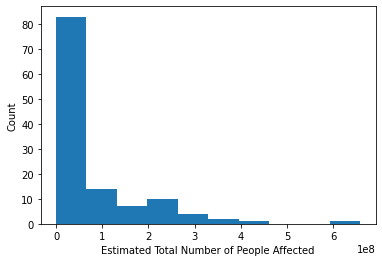

In [34]:
plt.hist(disaster_damages['total affected'])
plt.ylabel('Count')
plt.xlabel('Estimated Total Number of People Affected');

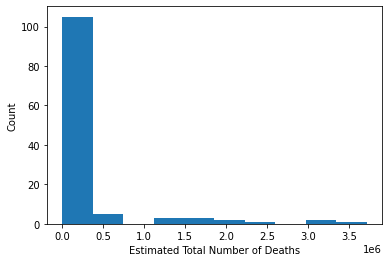

In [35]:
plt.hist(disaster_damages['total deaths'])
plt.ylabel('Count')
plt.xlabel('Estimated Total Number of Deaths');

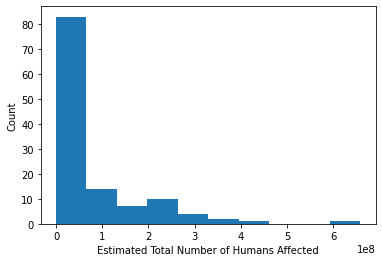

In [36]:
plt.hist(disaster_damages['total_human_affected'])
plt.ylabel('Count')
plt.xlabel('Estimated Total Number of Humans Affected');

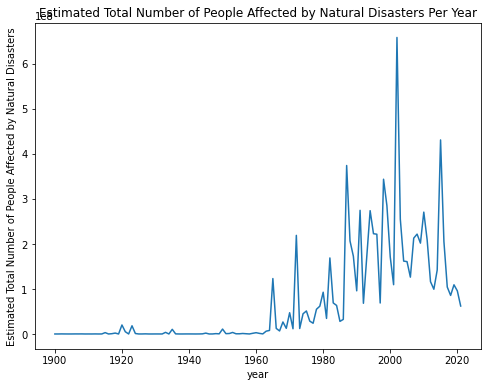

In [37]:
plt.subplots(figsize=(8, 6))
sns.lineplot(x='year', y='total affected', data=disaster_damages)
plt.ylabel('Estimated Total Number of People Affected by Natural Disasters')
plt.title('Estimated Total Number of People Affected by Natural Disasters Per Year');

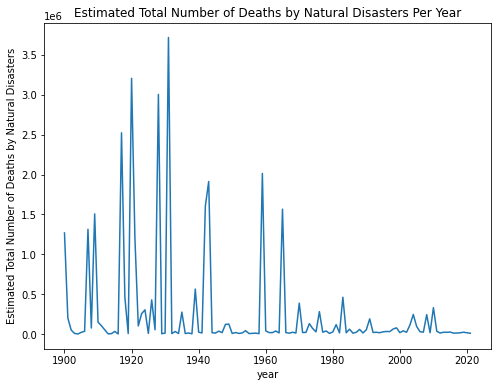

In [38]:
plt.figure(figsize=(8, 6))
sns.lineplot(x='year', y='total deaths', data=disaster_damages)
plt.ylabel('Estimated Total Number of Deaths by Natural Disasters')
plt.title('Estimated Total Number of Deaths by Natural Disasters Per Year');

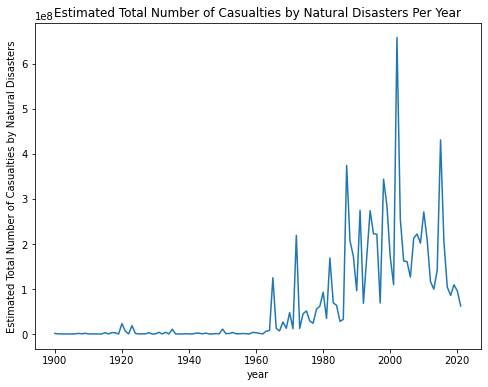

In [39]:
plt.figure(figsize=(8, 6))
sns.lineplot(x='year', y='total_human_affected', data=disaster_damages)
plt.ylabel('Estimated Total Number of Casualties by Natural Disasters')
plt.title('Estimated Total Number of Casualties by Natural Disasters Per Year');

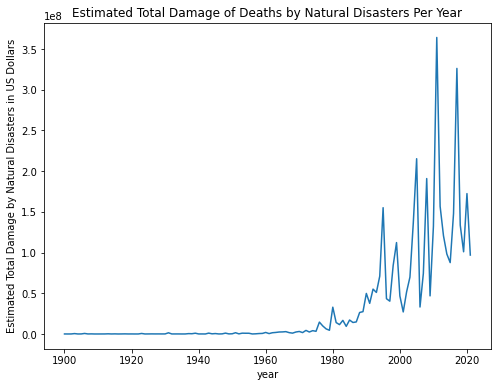

In [40]:
plt.figure(figsize=(8, 6))
sns.lineplot(x='year', y="total damages ('000 us$)", data=disaster_damages)
plt.ylabel('Estimated Total Damage by Natural Disasters in US Dollars')
plt.title('Estimated Total Damage of Deaths by Natural Disasters Per Year');

Total number of affected people may be a better measure for our global analysis here. I will include total number of combined events, total number of each event category, and total number of affected people.

In [41]:
global_summary = pd.merge(disaster_damages[['total_human_affected']], total_disasters, on='year') #+ total_disasters + disasters_year.iloc[:, :] 
global_summary = global_summary.merge(disasters_year, on='year')

In [42]:
global_summary.columns = global_summary.columns.str.lower()
global_summary

,total_human_affected,total disasters,biological,climatological,extra-terrestrial,geophysical,hydrological,meteorological
year,,,,,,,,
1900,1267500.0,7,1.0,2.0,NaN,2.0,1.0,1.0
1901,200042.0,2,1.0,NaN,NaN,1.0,NaN,NaN
1902,191090.0,10,NaN,NaN,NaN,9.0,NaN,1.0
1903,67159.0,12,NaN,1.0,NaN,7.0,2.0,2.0
1904,4121.0,4,NaN,NaN,NaN,3.0,NaN,1.0
...,...,...,...,...,...,...,...,...
2017,104226696.0,371,27.0,27.0,NaN,25.0,152.0,140.0
2018,85679803.0,338,16.0,27.0,NaN,30.0,141.0,124.0
2019,109274401.0,442,44.0,29.0,NaN,36.0,221.0,112.0


In [43]:
global_summary

,total_human_affected,total disasters,biological,climatological,extra-terrestrial,geophysical,hydrological,meteorological
year,,,,,,,,
1900,1267500.0,7,1.0,2.0,NaN,2.0,1.0,1.0
1901,200042.0,2,1.0,NaN,NaN,1.0,NaN,NaN
1902,191090.0,10,NaN,NaN,NaN,9.0,NaN,1.0
1903,67159.0,12,NaN,1.0,NaN,7.0,2.0,2.0
1904,4121.0,4,NaN,NaN,NaN,3.0,NaN,1.0
...,...,...,...,...,...,...,...,...
2017,104226696.0,371,27.0,27.0,NaN,25.0,152.0,140.0
2018,85679803.0,338,16.0,27.0,NaN,30.0,141.0,124.0
2019,109274401.0,442,44.0,29.0,NaN,36.0,221.0,112.0


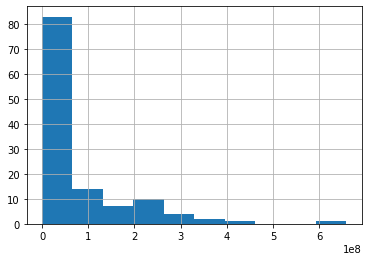

In [44]:
global_summary['total_human_affected'].hist();

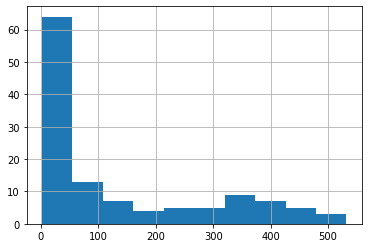

In [45]:
global_summary['total disasters'].hist();

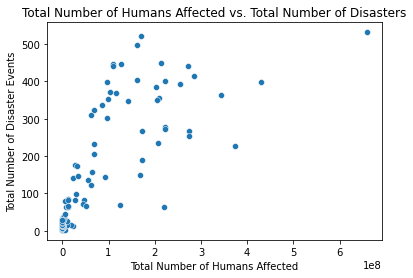

In [46]:
sns.scatterplot(x='total_human_affected', y='total disasters', data=global_summary)
plt.title('Total Number of Humans Affected vs. Total Number of Disasters')
plt.ylabel('Total Number of Disaster Events')
plt.xlabel('Total Number of Humans Affected')
plt.savefig('/content/drive/MyDrive/DS4A-W_Team25/Colab_Files/figures/casualties_vs_disasters.png');

In [47]:
np.cov(global_summary['total_human_affected'], global_summary['total disasters'])

array([[1.19304531e+16, 1.33610751e+10],
       [1.33610751e+10, 2.46698730e+04]])

In [48]:
corr = global_summary.corr()

In [49]:
corr

,total_human_affected,total disasters,biological,climatological,extra-terrestrial,geophysical,hydrological,meteorological
total_human_affected,1.000000,0.778806,0.688683,0.699827,NaN,0.730568,0.706232,0.738547
total disasters,0.778806,1.000000,0.808048,0.881084,NaN,0.908047,0.973658,0.973494
biological,0.688683,0.808048,1.000000,0.766229,NaN,0.702472,0.681838,0.696361
climatological,0.699827,0.881084,0.766229,1.000000,NaN,0.819978,0.774559,0.826769
extra-terrestrial,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
geophysical,0.730568,0.908047,0.702472,0.819978,NaN,1.000000,0.825738,0.900555
hydrological,0.706232,0.973658,0.681838,0.774559,NaN,0.825738,1.000000,0.927212
meteorological,0.738547,0.973494,0.696361,0.826769,NaN,0.900555,0.927212,1.000000


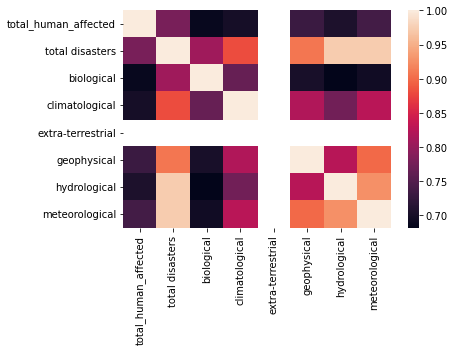

In [50]:
sns.heatmap(corr);

In [51]:
global_summary.columns = [
                          'total_human_affected',	'total_disasters',	'biological_disasters',	
                          'climatological_disasters',	'extra_terrestrial_disasters',	
                          'geophysical_disasters',	'hydrological_disasters',	'meteorological_disasters'
                          ]

In [52]:
model = 'total_human_affected~total_disasters'
lm   = ols(formula = model, data = global_summary).fit()
print(lm.summary())

                             OLS Regression Results                             
Dep. Variable:     total_human_affected   R-squared:                       0.607
Model:                              OLS   Adj. R-squared:                  0.603
Method:                   Least Squares   F-statistic:                     185.0
Date:                  Thu, 14 Oct 2021   Prob (F-statistic):           4.59e-26
Time:                          22:04:55   Log-Likelihood:                -2373.8
No. Observations:                   122   AIC:                             4752.
Df Residuals:                       120   BIC:                             4757.
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept       -3.074

There is some correlation between total number of disasters and total number of people affected. I will use total number of people affect per disaster as a proxy measure of total disaters.

In [53]:
global_summary['total_affected_per_disaster'] = global_summary['total_human_affected']/global_summary['total_disasters']

In [54]:
global_summary

,total_human_affected,total_disasters,biological_disasters,climatological_disasters,extra_terrestrial_disasters,geophysical_disasters,hydrological_disasters,meteorological_disasters,total_affected_per_disaster
year,,,,,,,,,
1900,1267500.0,7,1.0,2.0,NaN,2.0,1.0,1.0,181071.428571
1901,200042.0,2,1.0,NaN,NaN,1.0,NaN,NaN,100021.000000
1902,191090.0,10,NaN,NaN,NaN,9.0,NaN,1.0,19109.000000
1903,67159.0,12,NaN,1.0,NaN,7.0,2.0,2.0,5596.583333
1904,4121.0,4,NaN,NaN,NaN,3.0,NaN,1.0,1030.250000
...,...,...,...,...,...,...,...,...,...
2017,104226696.0,371,27.0,27.0,NaN,25.0,152.0,140.0,280934.490566
2018,85679803.0,338,16.0,27.0,NaN,30.0,141.0,124.0,253490.541420
2019,109274401.0,442,44.0,29.0,NaN,36.0,221.0,112.0,247227.151584


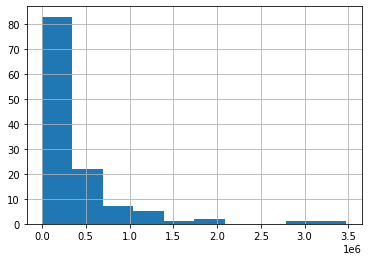

In [55]:
global_summary['total_affected_per_disaster'].hist();

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



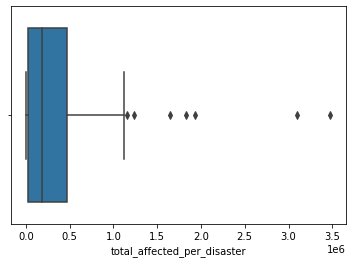

In [56]:
sns.boxplot(global_summary['total_affected_per_disaster']);

Most disasters affected ~100,000 people or less. 

After talking to the group, I will only keep 2 columns: `total_affected` and `total_disasters`

In [57]:
global_summary = global_summary.iloc[:, :2]

In [ ]:
# global_summary.to_csv('/content/drive/MyDrive/DS4A-W_Team25/Colab_Files/data/global_data/global_disasters.csv')

After talking to Anastasia, we will keep all countries without collapsing to a single global point.

In [58]:
dis_year_country

total disasters
year country                                            
1900 Cabo Verde                                        1
     India                                             1
     Jamaica                                           2
     Japan                                             1
     Turkey                                            1
...                                                  ...
2021 Uzbekistan                                        1
     Venezuela (Bolivarian Republic of)                2
     Viet Nam                                          4
     Yemen                                             2
     Zimbabwe                                          1

[5998 rows x 1 columns]

In [60]:
disasters.columns

Index(['dis no', 'year', 'seq', 'glide', 'disaster group', 'disaster subgroup',
       'disaster type', 'disaster subtype', 'disaster subsubtype',
       'event name', 'country', 'iso', 'region', 'continent', 'location',
       'origin', 'associated dis', 'associated dis2', 'ofda response',
       'appeal', 'declaration', 'aid contribution', 'dis mag value',
       'dis mag scale', 'latitude', 'longitude', 'local time', 'river basin',
       'start year', 'start month', 'start day', 'end year', 'end month',
       'end day', 'total deaths', 'no injured', 'no affected', 'no homeless',
       'total affected', 'reconstruction costs ('000 us$)',
       'insured damages ('000 us$)', 'total damages ('000 us$)', 'cpi',
       'adm level', 'admin1 code', 'admin2 code', 'geo locations',
       'total_human_affected'],
      dtype='object')

In [61]:
dis_year_iso = disasters.groupby(['year','iso', 'country', 'region', 'continent']).size().to_frame()
dis_year_iso.columns = ['number_of_disasters']
dis_year_iso

number_of_disasters
year iso country                            region             continent                     
1900 CPV Cabo Verde                         Western Africa     Africa                       1
     IND India                              Southern Asia      Asia                         1
     JAM Jamaica                            Caribbean          Americas                     2
     JPN Japan                              Eastern Asia       Asia                         1
     TUR Turkey                             Western Asia       Asia                         1
...                                                                                       ...
2021 VEN Venezuela (Bolivarian Republic of) South America      Americas                     2
     VNM Viet Nam                           South-Eastern Asia Asia                         4
     YEM Yemen                              Western Asia       Asia                         2
     ZAF South Africa                       Southern Africa    Africa                       2
     ZWE Zimbabwe                           Eastern Africa     Africa                       1

[5998 rows x 1 columns]

In [65]:
people_year_iso = disasters.groupby(['year','iso', 'country', 'region', 'continent']).sum()
people_year_iso = people_year_iso[['total_human_affected']]
people_year_iso

total_human_affected
year iso country                            region             continent                      
1900 CPV Cabo Verde                         Western Africa     Africa                  11000.0
     IND India                              Southern Asia      Asia                  1250000.0
     JAM Jamaica                            Caribbean          Americas                  330.0
     JPN Japan                              Eastern Asia       Asia                       30.0
     TUR Turkey                             Western Asia       Asia                      140.0
...                                                                                        ...
2021 VEN Venezuela (Bolivarian Republic of) South America      Americas              1401346.0
     VNM Viet Nam                           South-Eastern Asia Asia                     2246.0
     YEM Yemen                              Western Asia       Asia                    90384.0
     ZAF South Africa                       Southern Africa    Africa                   3635.0
     ZWE Zimbabwe                           Eastern Africa     Africa                   2003.0

[5998 rows x 1 columns]

In [66]:
disaster_joined = dis_year_iso.merge(people_year_iso, on=['year', 'iso', 'country', 'region', 'continent'], how='outer')

In [67]:
disaster_joined

number_of_disasters  total_human_affected
year iso country                            region             continent                                           
1900 CPV Cabo Verde                         Western Africa     Africa                       1               11000.0
     IND India                              Southern Asia      Asia                         1             1250000.0
     JAM Jamaica                            Caribbean          Americas                     2                 330.0
     JPN Japan                              Eastern Asia       Asia                         1                  30.0
     TUR Turkey                             Western Asia       Asia                         1                 140.0
...                                                                                       ...                   ...
2021 VEN Venezuela (Bolivarian Republic of) South America      Americas                     2             1401346.0
     VNM Viet Nam                           South-Eastern Asia Asia                         4                2246.0
     YEM Yemen                              Western Asia       Asia                         2               90384.0
     ZAF South Africa                       Southern Africa    Africa                       2                3635.0
     ZWE Zimbabwe                           Eastern Africa     Africa                       1                2003.0

[5998 rows x 2 columns]

In [68]:
disaster_joined.to_csv('/content/drive/MyDrive/DS4A-W_Team25/Colab_Files/data/global_data/natural_disasters.csv')

In [ ]:
viral_epidemic = disasters[disasters['disaster subtype'] == 'Viral disease']

In [ ]:
viral_epidemic